### Taken from https://github.com/aiguys/substation/blob/0d73fbff77c69f9f43fd98a77af22d2814119aa5/models/Android/tensorflow-yolo/tensorflow/lite/experimental/examples/lstm/TensorFlowLite_LSTM_Keras_Tutorial.ipynb

# DOCS
https://github.com/aiguys/substation/tree/0d73fbff77c69f9f43fd98a77af22d2814119aa5/models/Android/tensorflow-yolo/tensorflow/lite/experimental/examples/lstm/g3doc

# Steps 

1) Training & Evaluation.
First step is replacing tf.nn.rnn_cell.LSTMCell with tf.lite.experimental.nn.TFLiteLSTMCell in training phase, and replacing tf.nn.rnn.dynamic_rnn with tf.lite.experimental.nn.dynamic_rnn, if you are using dynamic_rnn. Note you don't need to change if you're using static_rnn.

Both tf.lite.experimental.nn.TFLiteLSTMCell & tf.lite.experimental.nn.dynamic_rnn are just normal tf.nn.rnn_cell.LSTMCell and tf.nn.rnn.dynamic_rnn with OpHinted nodes in it to help the graph transformation.

Then you can train and export the model as usual.

2) Export for TensorFlow Lite inference as usual.
When you want to convert to TensorFlow Lite model, you can simply get the session, then convert to TensorFlow Lite model.

Then you can convert the model to TensorFlow Lite model as usual.

# Overview
This codelab will demonstrate how to build a LSTM model for MNIST recognition using keras & how to convert the model to TensorFlow Lite.

---



In [0]:
# leave 1.15 tf until you have errors version mismatch related
#!pip install tf-nightly

     |████████████████████████████████| 466.8MB 37kB/s 
     |████████████████████████████████| 460kB 39.3MB/s 
     |████████████████████████████████| 2.9MB 33.1MB/s 
     |████████████████████████████████| 3.9MB 33.0MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
ERROR: tb-nightly 2.2.0a20200205 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [0]:
#Restart the kernel
#check version tf
#import tensorflow as tf
#tf.__version__

'2.2.0-dev20200204'

### Prerequisites
environment variable `TF_ENABLE_CONTROL_FLOW_V2` should be enabled since for TensorFlow Lite control flows.

In [2]:
# This is important!
import os
os.environ['TF_ENABLE_CONTROL_FLOW_V2'] = '1'

import tensorflow as tf
import numpy as np
from keras.utils import plot_model

Using TensorFlow backend.


## Step 1 Build the test LSTM model.

Note we will be using **`tf.lite.experimental.nn.TFLiteLSTMCell`** & **`tf.lite.experimental.nn.dynamic_rnn`** in the tutorial.

Also note here, we're not trying to build the model to be a real world application, but only demonstrates how to use TensorFlow lite. You can a build a much better model using CNN models.

For more canonical lstm codelab, please see [here](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py).

In [0]:
# Step 1: Build the MNIST LSTM model.

def buildLstmLayer(inputs, num_layers, num_units):
  """Build the lstm layer.

  Args:
    inputs: The input data.
    num_layers: How many LSTM layers do we want.
    num_units: The number of hidden units in the LSTM cell.
  """
  lstm_cells = []
  for i in range(num_layers):
    lstm_cells.append(
        tf.lite.experimental.nn.TFLiteLSTMCell(
            num_units, forget_bias=0, name='rnn{}'.format(i)))
  lstm_layers = tf.keras.layers.StackedRNNCells(lstm_cells)
  # Assume the input is sized as [batch, time, input_size], then we're going
  # to transpose to be time-majored.
  transposed_inputs = tf.transpose(
      inputs, perm=[1, 0, 2])
      #inputs, perm=[2, 3, 0, 1])
  outputs, _ = tf.lite.experimental.nn.dynamic_rnn(
      lstm_layers,
      transposed_inputs,
      dtype='float32',
      time_major=True)
  unstacked_outputs = tf.unstack(outputs, axis=0)
  return unstacked_outputs[-1]

tf.reset_default_graph()
#TODO add backbone
#base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(32,32,3), alpha=1.0, include_top=False, weights='imagenet', input_tensor=None, pooling=None)
model = tf.keras.models.Sequential([
 # base_model,                                  
  tf.keras.layers.Input(shape=(28, 28), name='input'),
  tf.keras.layers.Lambda(buildLstmLayer, arguments={'num_layers' : 3, 'num_units' : 128}),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax, name='output')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 128)               343552    
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 344,842
Trainable params: 344,842
Non-trainable params: 0
_________________________________________________________________


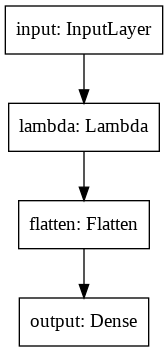

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='ocr1.png')

# Example 2 with backbone

In [3]:
# Step 1: Build the LSTM model with mobilenet backbone

def buildLstmLayer(inputs, num_layers, num_units):
  """Build the lstm layer.

  Args:
    inputs: The input data.
    num_layers: How many LSTM layers do we want.
    num_units: The number of hidden units in the LSTM cell.
  """
  lstm_cells = []
  for i in range(num_layers):
    lstm_cells.append(
        tf.lite.experimental.nn.TFLiteLSTMCell(
            num_units, forget_bias=0, name='rnn{}'.format(i)))
  lstm_layers = tf.keras.layers.StackedRNNCells(lstm_cells)
  # Assume the input is sized as [batch, time, input_size], then we're going
  # to transpose to be time-majored.
  transposed_inputs = tf.transpose(
      #inputs, perm=[2, 0, 2,2])
      inputs, perm=[1, 0, 2])
  outputs, _ = tf.lite.experimental.nn.dynamic_rnn(
      lstm_layers,
      transposed_inputs,
      dtype='float32',
      time_major=True)
  unstacked_outputs = tf.unstack(outputs, axis=0)

  return unstacked_outputs[-1]

#inputs_ = tf.placeholder(tf.float32, [32,32,3], name = "inputs")
#inputs_withextradim = tf.expand_dims(inputs_, 3)
#outputs, final_state = tf.nn.dynamic_rnn(cell, inputs_withextradim,  initial_state=initial_state)

# to prevent error rnn variable already exist
tf.reset_default_graph()

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=None, alpha=1.0, include_top=False, weights='imagenet', input_tensor=None, pooling=None)
model = tf.keras.models.Sequential([
  base_model, 
  tf.keras.layers.Reshape(target_shape=(32, 32), name='reshape'),                                
  tf.keras.layers.Input(shape=(32, 32), name='input'),
  tf.keras.layers.Lambda(buildLstmLayer, arguments={'num_layers' : 3, 'num_units' : 128}),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax, name='output')
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, None, None, 1280)  2257984   
_________________________________________________________________
reshape (Reshape)            (None, 32, 32)            0         
_________________________________________________________________
input (InputLayer)           multiple                  0         
_________________________________________________________________
lambda (Lambda)              (None, 128)               345600    
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 2,604,874
Trainable params: 2,570,762
Non-tra

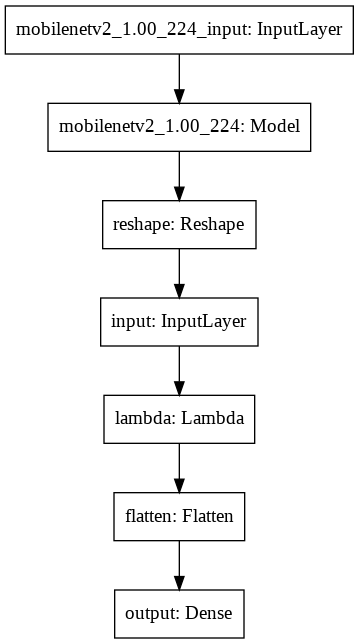

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='ocr2.png')

## Step 2: Train & Evaluate the model.
train the model using MNIST data.

In [4]:
import cv2
# Step 2: Train & Evaluate the model.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Cast x_train & x_test to float32.
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
reshape = lambda x: np.expand_dims(x, 3)

mapx_train = map(reshape, x_train)
mapx_test = map(reshape, x_test)

In [6]:
x_train = []
x_test = []

for it in mapx_train:
    x_train.append(it)
for it in mapx_test:
    x_test.append(it)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """Entry point for launching an IPython kernel.


###Datagenerator

In [0]:
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, df, mode = 'fit',
                 base_path = '../input/recursion-cellular-image-classification/train',
                 batch_size = 32, dim = (64, 512), n_channels = 1, size = 9,
                 rotation_range = 0, fill_mode = 'nearest',
                 vertical_flip = False, horizontal_flip = False, rescale = 1/255.,
                 n_classes = 5, random_state = 2019, shuffle = True, len_seq = 32, len_line = 8, is_serial = False):
      

        self.is_serial = is_serial


        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.size = size
        self.base_path = base_path
        self.rotation_range = rotation_range
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale = rescale
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
        self.random_state = random_state
        
        self.len_seq = len_seq
        np.random.seed(self.random_state)
        self.on_epoch_end()

        if(is_serial):
          self.len_line = 16
        else:
          self.len_line = 8

        

    def __len__(self):
        'Denotes the number of batches per epoch'
        #print('len')
        return int((len(self.df) / self.batch_size))

    def __getitem__(self, index):

        batch_files = self.df.iloc[index * self.batch_size:(index+1) * self.batch_size]
        
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = self.__generate_y(batch_files)
            return [X, y, np.ones((self.batch_size, 1)) * self.len_seq, self.cur_data], np.zeros([self.batch_size,1])
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
        buf = np.empty((self.batch_size, self.dim[0], self.dim[1], 3))

        for i in range(len(batch_files)):

          if self.mode == 'fit':
            b = cv2.imread(READ_DIR+str(batch_files.iloc[i]['data_index']) + '.png')
          else:
            b = cv2.imread(batch_files[i])

          b = cv2.resize(b, (self.dim[1], self.dim[0]))
          buf[i, ] = b
          
        buf = buf * self.rescale
        return buf
    
    def __generate_y(self, batch_files):
        y = np.ones((self.batch_size, self.len_line)) * 100
        self.cur_data = np.zeros((self.batch_size, 1))

        for i in range(len(batch_files)):
          if(self.is_serial):
            data = batch_files.iloc[i]['value_s'].strip()

          else:
            data = batch_files.iloc[i]['value_r'].strip()
          
          self.cur_data[i] = len(data)
          
          y[i, :len(data)] = text_to_labels(data, self.is_serial)
          
        return y

In [67]:
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

ValueError: ignored

train the model using dummy or CIFAR10 data.

In [9]:
# Dummy data

x_train = np.zeros([10,32,32,3])
y_train = np.zeros([10,32,32,3])

x_test = np.zeros([10,32,32,3])
y_test = np.zeros([10,32,32,3])

x_train, x_test = x_train / 255.0, x_test / 255.0

# Cast x_train & x_test to float32.
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)


# Step 2: Train & Evaluate the model.
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)


Train on 10 samples
Epoch 1/5


InvalidArgumentError: ignored

In [10]:
# Step 2: Train & Evaluate the model.
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Cast x_train & x_test to float32.
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

model.fit(x_train, y_train, epochs=1)
model.evaluate(x_test, y_test)

170500096/170498071 [==============================] - 6s 0us/step
Train on 50000 samples


InvalidArgumentError: ignored

# Save the model

In [0]:
model.save('ocr_lstm_example_model.h5')

## Step 3: Convert the Keras model to TensorFlow Lite model.

Note here: we just convert to TensorFlow Lite model as usual.

In [0]:
# Step 3: Convert the Keras model to TensorFlow Lite model.
sess = tf.keras.backend.get_session()
input_tensor = sess.graph.get_tensor_by_name('input:0')
output_tensor = sess.graph.get_tensor_by_name('output/Softmax:0')
converter = tf.lite.TFLiteConverter.from_session(
    sess, [input_tensor], [output_tensor])
tflite_ocr_model = converter.convert()
tflite_model_name = "ocr_lstm_example_model.tflite"
open(tflite_model_name, "wb").write(tflite_ocr_model)
print('Model converted and saved successfully!')

INFO:tensorflow:Froze 26 variables.
INFO:tensorflow:Converted 26 variables to const ops.
Model converted and saved successfully!


## Step 4: Check the converted TensorFlow Lite model.

We're just going to load the TensorFlow Lite model and use the TensorFlow Lite python interpreter to verify the results.

In [0]:
# Step 4: Check the converted TensorFlow Lite model.
interpreter = tf.lite.Interpreter(model_content=tflite_ocr_model)

try:
  interpreter.allocate_tensors()
except ValueError:
  assert False

MINI_BATCH_SIZE = 1
correct_case = 0
for i in range(len(x_test)):
  input_index = (interpreter.get_input_details()[0]['index'])
  interpreter.set_tensor(input_index, x_test[i * MINI_BATCH_SIZE: (i + 1) * MINI_BATCH_SIZE])
  interpreter.invoke()
  output_index = (interpreter.get_output_details()[0]['index'])
  result = interpreter.get_tensor(output_index)
  # Reset all variables so it will not pollute other inferences.
  interpreter.reset_all_variables()
  # Evaluate.
  prediction = np.argmax(result)
  if prediction == y_test[i]:
    correct_case += 1

print('TensorFlow Lite Evaluation result is {}'.format(correct_case * 1.0 / len(x_test)))

TensorFlow Lite Evaluation result is 0.9828


In [0]:
#Print input and output details

import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_ocr_model)

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.allocate_tensors()

# Get input and output tensors.



# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.zeros(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()


print(input_details)
print("-----------------------")
print(output_details)